In [14]:
import os, sys, math, warnings
from pathlib import Path
from typing import Optional, Dict, Tuple, List
import joblib
from IPython.display import Image, display

import numpy as np
import pandas as pd
from skimage import io, color, filters, morphology, measure, segmentation, util
from skimage.transform import rescale
from skimage.color import separate_stains, hed_from_rgb
import networkx as nx
from sklearn.neighbors import kneighbors_graph
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score,classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split

warnings.filterwarnings("ignore")

try:
    import openslide
    _HAS_OPENSLIDE = True
except Exception:
    _HAS_OPENSLIDE = False

try:
    import squidpy as sq
    _HAS_SQ = True
except Exception:
    _HAS_SQ = False


In [15]:
def _rgba2rgb(a, bg=(255,255,255)):
    if a.ndim == 3 and a.shape[2] == 4:
        rgb = a[..., :3].astype(float)
        alpha = (a[..., 3:4].astype(float) / 255.0)
        bg = np.array(bg, dtype=float).reshape(1,1,3)
        rgb = rgb * alpha + bg * (1.0 - alpha)
        return rgb.astype(np.uint8)
    return a

def read_svs_level(path: str, level: Optional[int], min_dim: int = 3000):
    """Return (rgb, used_level). If openslide is not available or level is None, return a thumbnail instead."""
    p = str(path)
    if _HAS_OPENSLIDE and p.lower().endswith(('.svs','.tif','.tiff','.ndpi','.mrxs','.bif','.scn')):
        slide = openslide.OpenSlide(p)
        if level is None:
            w0, h0 = slide.dimensions
            scale = max(w0, h0) / float(min_dim)
            new_w, new_h = int(w0/scale), int(h0/scale)
            img = np.array(slide.get_thumbnail((new_w, new_h)))
            slide.close()
            return img, None
        else:
            level = int(level)
            if level < 0 or level >= slide.level_count:
                raise ValueError(f"level={level} is out of range（maximum is {slide.level_count-1}）")
            w, h = slide.level_dimensions[level]
            img = slide.read_region((0,0), level, (w,h))
            slide.close()
            img = _rgba2rgb(np.array(img))
            return img, level
    else:
        img = io.imread(p)
        H, W = img.shape[:2]
        scale = max(H, W) / float(min_dim)
        if scale > 1:
            img = util.img_as_ubyte(rescale(img, 1/scale, channel_axis=-1, anti_aliasing=True))
        return img, None

def tissue_mask(rgb, blur_sigma: float = 1.0):
    """"Simple tissue mask using HSV + Otsu."""
    hsv = color.rgb2hsv(rgb)
    s = filters.gaussian(hsv[...,1], blur_sigma)
    v = filters.gaussian(hsv[...,2], blur_sigma)
    thr_s = filters.threshold_otsu(s)
    thr_v = filters.threshold_otsu(v)
    mask = (s > thr_s*0.9) & (v < thr_v*1.1)
    mask = morphology.remove_small_objects(mask.astype(bool), 512)
    mask = morphology.remove_small_holes(mask, 512)
    return mask.astype(np.uint8)


In [16]:
def slic_nodes(rgb, mask, n_segments=800, compactness=20.0, enforce_connectivity=True):
    masked = rgb.copy()
    masked[mask == 0] = 255
    labels = segmentation.slic(
        masked, n_segments=n_segments, compactness=compactness,
        start_label=0, convert2lab=True, enforce_connectivity=enforce_connectivity
    )
    labels[mask == 0] = -1
    props = measure.regionprops(labels + 1)
    centroids = np.zeros((labels.max() + 1, 2), dtype=float)
    for r in props:
        lab = r.label - 1
        coords = r.coords
        coords = coords[mask[coords[:,0], coords[:,1]] > 0]
        centroids[lab] = coords.mean(axis=0) if len(coords) else np.array([np.nan, np.nan])
    valid = ~np.isnan(centroids).any(axis=1)
    remap = -np.ones(len(valid), dtype=int)
    remap[valid] = np.arange(valid.sum())
    new_labels = -np.ones_like(labels)
    for old in np.where(valid)[0]:
        new_labels[labels == old] = remap[old]
    return new_labels, centroids[valid]

def grid_nodes(rgb, mask, tile=256):
    H, W = mask.shape
    labels = -np.ones((H, W), dtype=int)
    lab = 0
    cents = []
    for y0 in range(0, H, tile):
        for x0 in range(0, W, tile):
            y1, x1 = min(H, y0+tile), min(W, x0+tile)
            m = mask[y0:y1, x0:x1]
            if m.sum() < tile*tile*0.05:  # Tissue area ratio threshold
                continue
            labels[y0:y1, x0:x1] = lab
            cents.append([(y0+y1)/2.0, (x0+x1)/2.0])
            lab += 1
    return labels, np.asarray(cents, dtype=float) if cents else np.zeros((0,2), dtype=float)


In [17]:
def node_features(rgb, labels):
    hsv = color.rgb2hsv(rgb)
    gray = color.rgb2gray(rgb).astype(float)
    L = max(0, labels.max()) + 1
    feats = []
    for lab in range(L):
        m = (labels == lab)
        if m.sum() == 0:
            feats.append(np.zeros(12)); continue
        r = rgb[...,0][m].mean(); g = rgb[...,1][m].mean(); b = rgb[...,2][m].mean()
        h = hsv[...,0][m].mean(); s = hsv[...,1][m].mean(); v = hsv[...,2][m].mean()
        gr = gray[m]; mu = gr.mean(); var = gr.var(); p10,p50,p90 = np.percentile(gr,[10,50,90])
        feats.append([r,g,b,h,s,v,mu,var,p10,p50,p90,gr.std()])
    return np.asarray(feats, dtype=float)

def build_knn_graph(centroids, k=8):
    if len(centroids) == 0: return nx.Graph()
    A = kneighbors_graph(centroids, n_neighbors=k, mode='connectivity', include_self=False)
    G = nx.from_scipy_sparse_array(A)
    for i,(y,x) in enumerate(centroids):
        G.nodes[i]['y'] = float(y); G.nodes[i]['x'] = float(x)
    return G

def gradient_map_he(rgb):
    try:
        HED = separate_stains(rgb, hed_from_rgb)
        H = HED[...,0]
    except Exception:
        H = color.rgb2gray(rgb)
    gx = filters.sobel_h(H); gy = filters.sobel_v(H)
    g = np.hypot(gx, gy)
    g = (g - g.min()) / (g.max() - g.min() + 1e-9)
    return g

def edge_weight_from_gradient(G, labels, gmap, alpha=3.0, rgb=None):
    L = max(0, labels.max()) + 1
    node_g = np.zeros(L); node_mu = np.zeros(L)
    gray = color.rgb2gray(rgb) if (rgb is not None and rgb.ndim == 3) else None
    if gray is None:
        gray = color.rgb2gray(util.img_as_ubyte(np.dstack([labels.clip(min=0)]*3)))
    for lab in range(L):
        m = (labels == lab)
        if m.sum() == 0: continue
        node_g[lab] = gmap[m].mean()
        node_mu[lab] = gray[m].mean()
    mu_std = node_mu.std() + 1e-6
    for i,j in G.edges():
        dg = abs(node_g[i] - node_g[j]); sim_g = math.exp(-alpha * dg)
        dc = abs(node_mu[i] - node_mu[j]) / mu_std; sim_c = math.exp(-0.5 * (dc ** 2))
        G.edges[i,j]['weight'] = float(max(1e-6, sim_g * sim_c))
    return G

In [18]:
def biased_random_walk_features(G, steps=4000, restarts=15, seed=42):
    rng = np.random.default_rng(seed)
    P = {}
    for i in G.nodes():
        nbrs = list(G.neighbors(i))
        if not nbrs: P[i] = ([], []); continue
        w = np.array([G.edges[i,j].get('weight',1.0) for j in nbrs], dtype=float)
        w = w / (w.sum() + 1e-12)
        P[i] = (nbrs, w)
    V = list(G.nodes()); n = len(V)
    if n == 0:
        return {'walk_visit': np.zeros(0), 'walk_first_hit': np.zeros(0), 'walk_out_entropy': np.zeros(0)}
    visit = np.zeros(n); first_hit_sum = np.zeros(n); first_hit_cnt = np.zeros(n)
    for r in range(restarts):
        cur = int(rng.integers(0, n)); seen = np.full(n, -1, dtype=int)
        for t in range(steps):
            visit[cur] += 1.0
            if seen[cur] < 0: seen[cur] = t
            nbrs, w = P[cur]
            if not nbrs: cur = int(rng.integers(0, n)); continue
            cur = int(rng.choice(nbrs, p=w))
        hit = (seen >= 0)
        first_hit_sum[hit] += seen[hit]; first_hit_cnt[hit] += 1
    visit = visit / (visit.sum() + 1e-12)
    avg_first_hit = first_hit_sum / (first_hit_cnt + 1e-9)
    node_entropy = np.zeros(n)
    for i in V:
        nbrs, w = P[i]
        node_entropy[i] = 0.0 if len(w)==0 else -float(np.sum(w * np.log(w + 1e-12)))
    return {'walk_visit': visit, 'walk_first_hit': avg_first_hit, 'walk_out_entropy': node_entropy}

def heterogeneity_features(labels, feats_node, centroids):
    out = {}
    valid = ~np.isnan(centroids).any(axis=1)
    yx = centroids[valid]; F = feats_node[valid]
    if len(F) == 0: return {'het_var_rgb': 0.0}
    rep = F[:,6] if F.shape[1] >= 7 else F.mean(axis=1)
    if _HAS_SQ:
        import anndata as ad
        adata = ad.AnnData(X=rep.reshape(-1,1))
        adata.obsm['spatial'] = np.stack([yx[:,1], yx[:,0]], axis=1)
        sq.gr.spatial_neighbors(adata, coord_type='generic', n_neigh=8)
        sq.gr.spatial_autocorr(adata, mode='moran'); out['moranI'] = float(adata.uns['moranI']['I'].values[0])
        try:
            sq.gr.spatial_autocorr(adata, mode='geary'); out['gearyC'] = float(adata.uns['geary']['C'].values[0])
        except Exception:
            pass
        from sklearn.neighbors import NearestNeighbors
        nn = NearestNeighbors(n_neighbors=8).fit(yx)
        idx = nn.kneighbors(return_distance=False)
        local_var = np.array([np.var(rep[idx[i]]) for i in range(len(yx))])
        hist,_ = np.histogram(local_var, bins=16, density=True)
        p = hist / (hist.sum() + 1e-12)
        out['local_var_entropy'] = float(-(p * np.log(p + 1e-12)).sum())
    else:
        out['het_var'] = float(np.var(rep))
        out['het_cv'] = float(np.std(rep) / (np.mean(rep) + 1e-9))
    return out

def summarize_graph_features(walk, feats_node):
    out = {}
    for name, vec in walk.items():
        v = np.asarray(vec, dtype=float)
        if v.size == 0:
            out[f'{name}_mean']=0.0; out[f'{name}_std']=0.0
            for pp in [10,25,50,75,90]: out[f'{name}_p{pp}']=0.0
            continue
        out[f'{name}_mean'] = float(np.mean(v))
        out[f'{name}_std']  = float(np.std(v))
        p = np.percentile(v, [10,25,50,75,90])
        out.update({f'{name}_p{int(pp)}': float(x) for pp,x in zip([10,25,50,75,90], p)})
    if 'walk_visit' in walk and feats_node.shape[0] == walk['walk_visit'].shape[0] and feats_node.shape[1] >= 8:
        w = walk['walk_visit'] / (walk['walk_visit'].sum() + 1e-12)
        out['visit_weighted_var'] = float((w * feats_node[:,7]).sum())
    return out

In [19]:
def process_one_image_one_level(path, level, node_mode, segments, tile, k, alpha, save_vis=False, vis_dir=None):
    rgb, used_level = read_svs_level(path, level=level, min_dim=3000)
    mask = tissue_mask(rgb)
    if node_mode == 'grid':
        labels, cents = grid_nodes(rgb, mask, tile=tile)
    else:
        labels, cents = slic_nodes(rgb, mask, n_segments=segments, compactness=20.0)
    feats_node = node_features(rgb, labels)
    G = build_knn_graph(cents, k=k)
    gmap = gradient_map_he(rgb)
    G = edge_weight_from_gradient(G, labels, gmap, alpha=alpha, rgb=rgb)
    walk = biased_random_walk_features(G, steps=4000, restarts=15, seed=42)

    f_graph = summarize_graph_features(walk, feats_node)
    f_het   = heterogeneity_features(labels, feats_node, cents)
    feats = {**f_graph, **f_het}

    # Visualization
    if save_vis and vis_dir is not None and 'walk_visit' in walk and (labels.max() + 1) == walk['walk_visit'].shape[0]:
        vis = np.zeros(labels.shape, dtype=float)
        wv = walk['walk_visit']
        for lab in range(labels.max()+1):
            vis[labels == lab] = wv[lab]
        vis = (vis - vis.min()) / (vis.max() - vis.min() + 1e-9)
        import matplotlib.pyplot as plt
        fig = plt.figure(figsize=(8,8))
        plt.imshow(rgb); plt.imshow(vis, alpha=0.45); plt.axis('off')
        lev_str = f"L{used_level}" if used_level is not None else "thumb"
        out_name = Path(vis_dir) / f"vis_{Path(path).stem}_{lev_str}.png"
        fig.savefig(out_name, bbox_inches='tight', dpi=180); plt.close(fig)

    lev_tag = f"L{used_level}" if used_level is not None else "thumb"
    feats = {f"{k}_{lev_tag}": v for k,v in feats.items()}
    return feats

In [20]:
DATA_ROOT = r"C:\Users\mxjli\Desktop\total"    # root directory containing stage1~stage4 folders
LEVELS    = [2]            # use higher pyramid levels if memory is limited (larger number = lower resolution); can also be [1, 2]
NODE_MODE = "slic"         # or "grid"
SEGMENTS  = 600            # number of SLIC superpixels
TILE      = 256            # patch size in grid mode
KNN_K     = 8
ALPHA     = 3.0
MAX_PER_CLASS = None          # use a subset for debugging or small-sample testing
SAVE_VIS  = True
TEST_SIZE = 0.2

out_dir = Path("final_results"); out_dir.mkdir(parents=True, exist_ok=True)
vis_dir = out_dir if SAVE_VIS else None

def load_dataset(root: str, max_per_class=None):
    root = Path(root); paths, labels = [], []
    for i, cls in enumerate(sorted([d for d in root.iterdir() if d.is_dir()])):
        cnt = 0
        for p in sorted(cls.glob("*")):
            if p.suffix.lower() in [".svs",".tif",".tiff",".ndpi",".mrxs",".bif",".scn",".png",".jpg",".jpeg"]:
                paths.append(str(p)); labels.append(i); cnt += 1
                if max_per_class is not None and cnt >= max_per_class: break
    return paths, np.array(labels, dtype=int)

paths, y = load_dataset(DATA_ROOT, max_per_class=MAX_PER_CLASS)
len(paths), np.bincount(y)

(204, array([44, 97, 53, 10]))

In [21]:
rows = []
for i, p in enumerate(paths):
    per_level_feats = {}
    level_list = LEVELS if (LEVELS and len(LEVELS) > 0) else [None]
    for lev in level_list:
        try:
            f_lev = process_one_image_one_level(
                p, level=lev, node_mode=NODE_MODE, segments=SEGMENTS, tile=TILE,
                k=KNN_K, alpha=ALPHA, save_vis=SAVE_VIS, vis_dir=vis_dir
            )
            per_level_feats.update(f_lev)
        except Exception as e:
            print(f"[WARN] {Path(p).name} @level {lev}: {e}")
    per_level_feats["path"]  = p
    per_level_feats["label"] = int(y[i])
    rows.append(per_level_feats)
    print(f"[{i+1}/{len(paths)}] {Path(p).name} -> {len(per_level_feats)} feats")

df = pd.DataFrame(rows).fillna(0)
feat_cols = [c for c in df.columns if c not in ("path","label")]
df.to_csv(out_dir / "features.csv", index=False)
df.head(3)

[1/204] TCGA-A1-A0SB-01Z-00-DX1.B34C267B-CAAA-4AB6-AD5C-276C26F997A1.svs -> 26 feats
[2/204] TCGA-A1-A0SE-01Z-00-DX1.04B09232-C6C4-46EF-AA2C-41D078D0A80A.svs -> 26 feats
[3/204] TCGA-A2-A0CP-01Z-00-DX1.ECFD263C-BB17-4ADA-8F2C-654C2AA4C45F.svs -> 26 feats
[4/204] TCGA-A2-A0EO-01Z-00-DX1.D7A09E23-2CAB-4B3B-814C-BF0BA75B7589.svs -> 26 feats
[5/204] TCGA-A2-A0EU-01Z-00-DX1.13335BEB-63D4-469B-A389-8A079A096129.svs -> 26 feats
[6/204] TCGA-A2-A0SX-01Z-00-DX1.219A994C-8974-4458-98FA-FB1F14868E04.svs -> 26 feats
[7/204] TCGA-A8-A0AD-01Z-00-DX1.A831FB53-7605-4138-9341-6BBCA284441C.svs -> 26 feats
[8/204] TCGA-AN-A0FY-01Z-00-DX1.25F5E2A1-F92C-4FE1-BD90-0CDDE50DC066.svs -> 26 feats
[9/204] TCGA-AO-A03M-01Z-00-DX1.9998A9A0-D0A6-48FC-80FB-AE597CB9E8AA.svs -> 26 feats
[10/204] TCGA-AO-A03V-01Z-00-DX1.52EBCB72-0C65-4E67-B9BB-DA15494327DE.svs -> 26 feats
[11/204] TCGA-AO-A0J4-01Z-00-DX1.2EFC978E-8DF5-4254-9598-C0910B17C5C8.svs -> 26 feats
[12/204] TCGA-AR-A1AJ-01Z-00-DX1.34B9FCF0-74D8-4328-9B5A-698AD5

,walk_visit_mean_L2,walk_visit_std_L2,walk_visit_p10_L2,walk_visit_p25_L2,walk_visit_p50_L2,walk_visit_p75_L2,walk_visit_p90_L2,walk_first_hit_mean_L2,walk_first_hit_std_L2,walk_first_hit_p10_L2,...,walk_out_entropy_p10_L2,walk_out_entropy_p25_L2,walk_out_entropy_p50_L2,walk_out_entropy_p75_L2,walk_out_entropy_p90_L2,visit_weighted_var_L2,het_var_L2,het_cv_L2,path,label
0,0.001802,0.004890,0.000933,0.001050,0.001183,0.001350,0.001600,581.907247,264.379878,289.48,...,2.078229,2.079442,2.079442,2.196062,2.386360,0.003981,0.127651,1.098409,C:\Users\mxjli\Desktop\total\stage 1\TCGA-A1-A...,0
1,0.002008,0.002517,0.001178,0.001333,0.001667,0.001967,0.002333,682.568597,396.094334,209.88,...,2.076281,2.079119,2.079442,2.196314,2.301907,0.006575,0.093106,0.629748,C:\Users\mxjli\Desktop\total\stage 1\TCGA-A1-A...,0
2,0.002288,0.004357,0.001067,0.001167,0.001400,0.002217,0.002707,418.688215,163.497475,235.55,...,2.075010,2.079442,2.079442,2.181518,2.296250,0.010687,0.074737,1.076303,C:\Users\mxjli\Desktop\total\stage 1\TCGA-A2-A...,0


In [22]:
# ============================================================
# 1️⃣ Load Dataset
# ============================================================
df = pd.read_csv(r"C:\Users\mxjli\PyCharmMiscProject\final_results\features.csv")

out_dir = Path(r"C:\Users\mxjli\PyCharmMiscProject\final_results")
out_dir.mkdir(parents=True, exist_ok=True)

feat_cols = df.columns[:24]
X = df[feat_cols]
y = df["label"]

# Standardization
scaler = StandardScaler()
Xs = pd.DataFrame(scaler.fit_transform(X), columns=feat_cols)

# ============================================================
# 2️⃣ Model Training and Cross-Validation
# ============================================================
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_f1 = []
best_fold = None
best_f1 = -1
best_y_true, best_y_pred = None, None

for fold, (train_idx, val_idx) in enumerate(kf.split(Xs, y), 1):
    print(f"\n===== Fold {fold} =====")

    X_tr, X_val = Xs.iloc[train_idx], Xs.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # ============================================================
    # Random Forest with Best Hyperparameters from Search
    # ============================================================
    clf = RandomForestClassifier(
        n_estimators=600,
        min_samples_split=5,
        min_samples_leaf=1,
        max_features="log2",
        max_depth=20,
        criterion="gini",
        bootstrap=True,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )

    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_val)

    f1 = f1_score(y_val, y_pred, average="macro")
    fold_f1.append(f1)
    print(f"Fold {fold} Macro-F1: {f1:.4f}")

    # Track the best fold
    if f1 > best_f1:
        best_f1 = f1
        best_fold = fold
        best_y_true = y_val
        best_y_pred = y_pred

# ============================================================
# 3️⃣ Results Summary
# ============================================================
mean_f1 = np.mean(fold_f1)
std_f1 = np.std(fold_f1)

print("\n===== Cross-Validation Summary =====")
print(f"Mean Macro-F1: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"Best Fold: {best_fold} (F1 = {best_f1:.4f})")

report = classification_report(best_y_true, best_y_pred, digits=4)
cm = confusion_matrix(best_y_true, best_y_pred)

print("\n===== Best Fold Classification Report =====")
print(report)
print("Confusion Matrix:\n", cm)

# ============================================================
# 4️⃣ Save Report
# ============================================================
with open(out_dir / "lightgbm_cv_report.txt", "w", encoding="utf-8") as f:
    f.write(f"Mean Macro-F1: {mean_f1:.4f} ± {std_f1:.4f}\n")
    f.write(f"Best Fold: {best_fold} (F1 = {best_f1:.4f})\n\n")
    f.write(report + "\nConfusion Matrix:\n")
    for row in cm:
        f.write(" ".join(map(str, row)) + "\n")

print(f"\n✅ Report saved to {out_dir / 'rf_cv_report.txt'}")


===== Fold 1 =====
Fold 1 Macro-F1: 0.2998

===== Fold 2 =====
Fold 2 Macro-F1: 0.2466

===== Fold 3 =====
Fold 3 Macro-F1: 0.3416

===== Fold 4 =====
Fold 4 Macro-F1: 0.4743

===== Fold 5 =====
Fold 5 Macro-F1: 0.3750

===== Cross-Validation Summary =====
Mean Macro-F1: 0.3475 ± 0.0766
Best Fold: 4 (F1 = 0.4743)

===== Best Fold Classification Report =====
              precision    recall  f1-score   support

           0     0.6000    0.6667    0.6316         9
           1     0.7895    0.7895    0.7895        19
           2     0.5000    0.4545    0.4762        11
           3     0.0000    0.0000    0.0000         2

    accuracy                         0.6341        41
   macro avg     0.4724    0.4777    0.4743        41
weighted avg     0.6317    0.6341    0.6323        41

Confusion Matrix:
 [[ 6  1  1  1]
 [ 2 15  2  0]
 [ 2  3  5  1]
 [ 0  0  2  0]]

✅ Report saved to C:\Users\mxjli\PyCharmMiscProject\final_results\rf_cv_report.txt


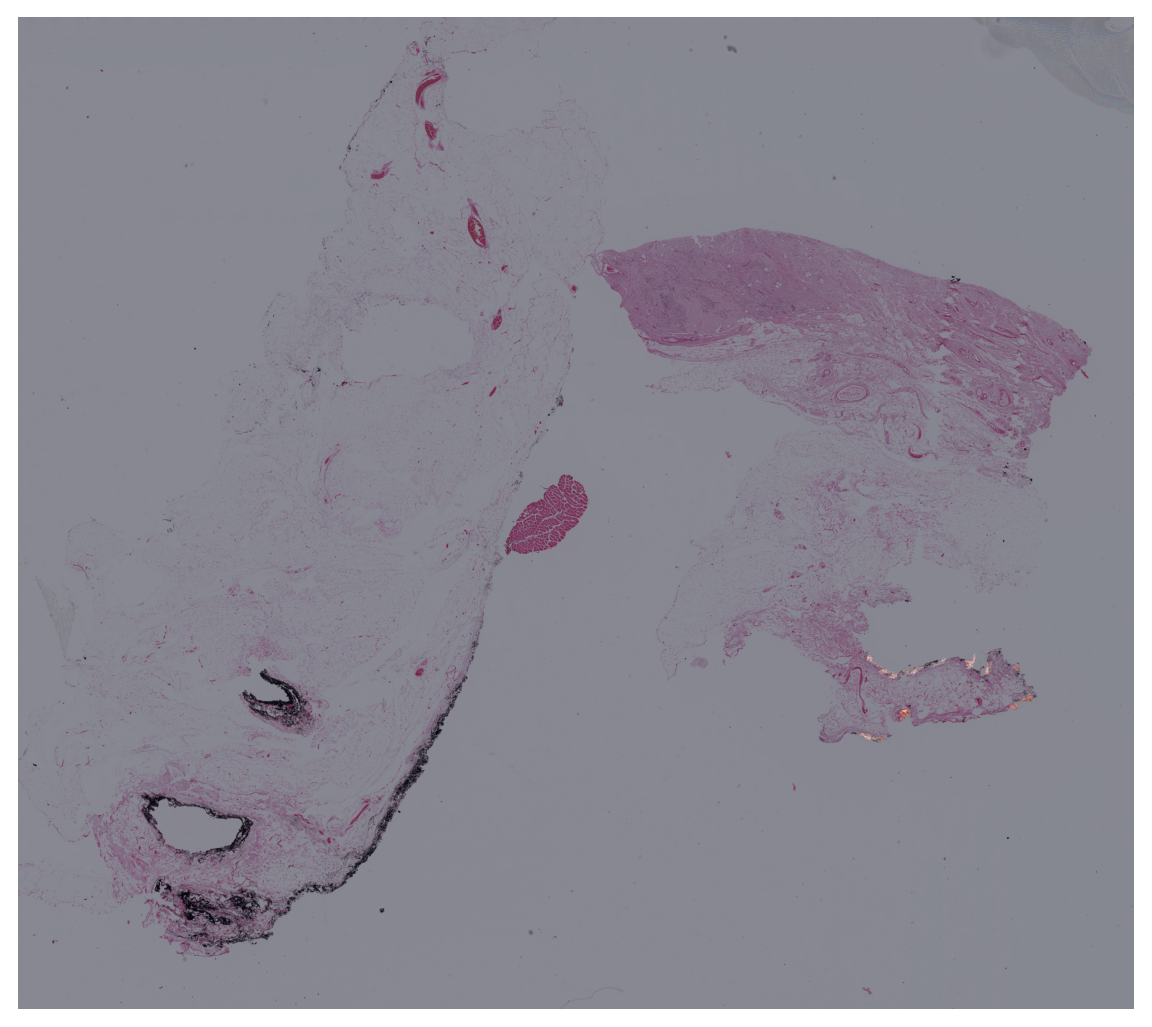

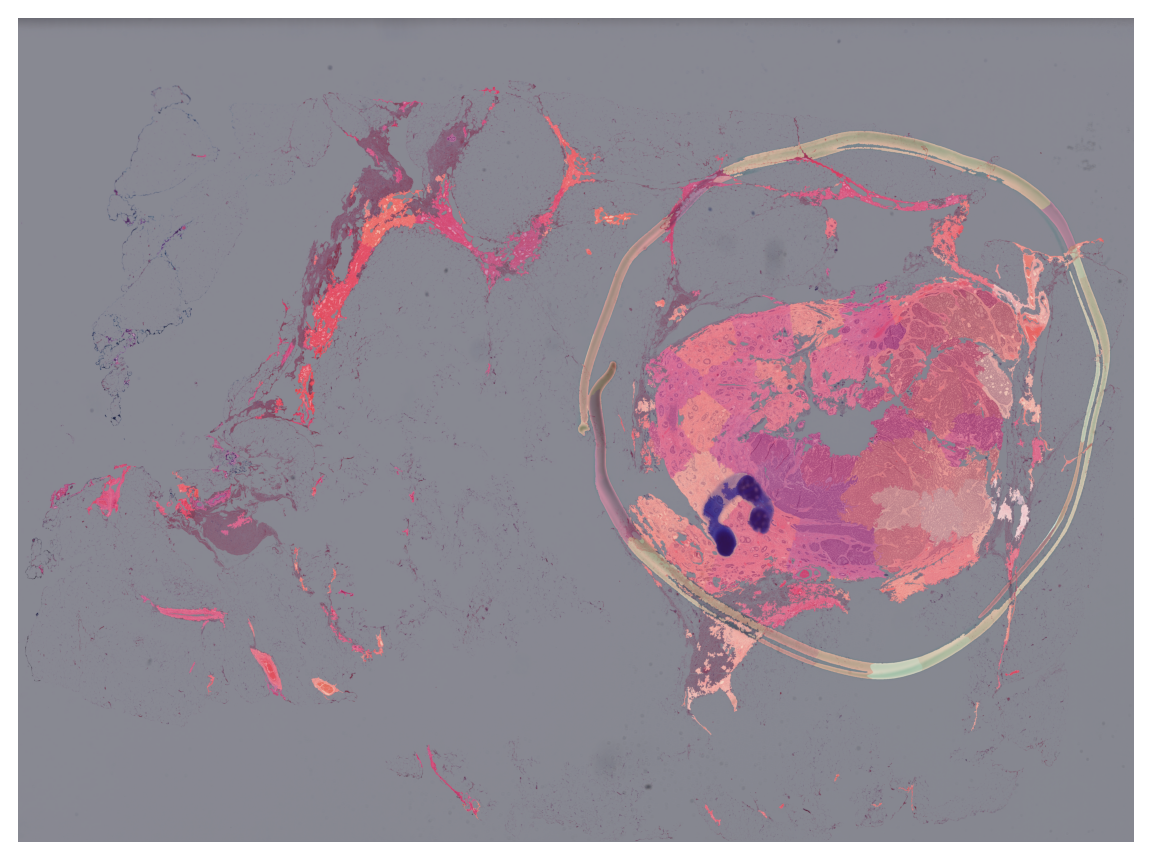

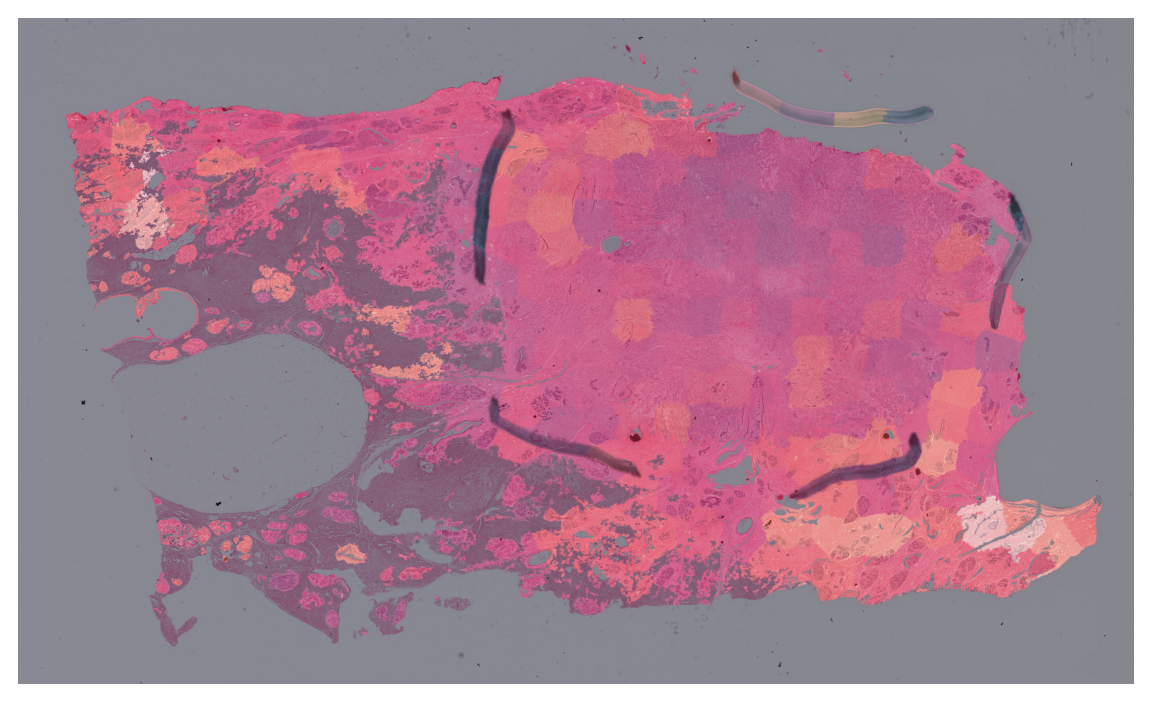

[None, None, None]

In [23]:
vis = sorted(out_dir.glob("vis_*"))[:3]
[display(Image(filename=str(p))) for p in vis]

In [24]:
def save_trained_model(clf, scaler, feat_cols, out_dir="final_results"):
    """
    Save the trained model and the scaler as a .pkl file.
    """
    out_dir = Path(out_dir)
    out_dir.mkdir(exist_ok=True, parents=True)

    joblib.dump(clf, out_dir / "stage_classifier.pkl")
    joblib.dump(scaler, out_dir / "scaler.pkl")
    joblib.dump(feat_cols, out_dir / "feat_cols.pkl")

    print("The model and the scaler have been saved.：")
    print(f"  ├── {out_dir/'stage_classifier.pkl'}")
    print(f"  ├── {out_dir/'scaler.pkl'}")
    print(f"  └── {out_dir/'feat_cols.pkl'}")

# Call the save function to store the model
save_trained_model(clf, scaler, feat_cols)

The model and the scaler have been saved.：
  ├── final_results\stage_classifier.pkl
  ├── final_results\scaler.pkl
  └── final_results\feat_cols.pkl


Test feature extraction

In [25]:
# ==== Configuration ====
DATA_ROOT = r"C:\Users\mxjli\Desktop\test total"  # root directory containing .svs files
LEVELS = [2]              # same as used during training
NODE_MODE = "slic"
SEGMENTS = 600
TILE = 256
KNN_K = 8
ALPHA = 3.0

# Output file path
OUT_CSV = Path("final_results/features_test.csv")
OUT_CSV.parent.mkdir(parents=True, exist_ok=True)

# ==== Feature Extraction ====
rows = []
svs_files = sorted(Path(DATA_ROOT).glob("*.svs"))
print(f"\n===== Found {len(svs_files)} slides in {DATA_ROOT} =====")

for i, p in enumerate(svs_files, 1):
    try:
        per_level_feats = {}
        for lev in LEVELS:
            f_lev = process_one_image_one_level(
                p, level=lev, node_mode=NODE_MODE,
                segments=SEGMENTS, tile=TILE, k=KNN_K, alpha=ALPHA,
                save_vis=False
            )
            per_level_feats.update(f_lev)
        # Only keep the slide path, no labels
        per_level_feats["path"] = str(p)
        rows.append(per_level_feats)
        print(f"[{i}/{len(svs_files)}] {p.name} -> {len(per_level_feats)} features")

    except Exception as e:
        print(f"[WARN] {p.name} failed: {e}")

# ==== Save as CSV ====
if len(rows) == 0:
    print("[ERROR] No features extracted. Please check process_one_image_one_level().")
else:
    df_test = pd.DataFrame(rows).fillna(0)

    # Ensure 'path' is the last column
    cols = [c for c in df_test.columns if c != "path"]
    df_test = df_test[cols + ["path"]]

    df_test.to_csv(OUT_CSV, index=False)
    print(f"\n✅ All features are extracted, total {len(df_test)} samples")
    print(f"✅ Saved to: {OUT_CSV.resolve()}")


===== Found 28 slides in C:\Users\mxjli\Desktop\test total =====
[1/28] TCGA-A1-A0SN-01Z-00-DX1.5E9B85AE-AFB7-41DC-8A1B-BD6DA39B6540.svs -> 25 features
[2/28] TCGA-A2-A04N-01Z-00-DX1.9E9B7DB0-1CF1-4631-8292-A9DBCA0BD37C.svs -> 25 features
[3/28] TCGA-A2-A04R-01Z-00-DX1.BE3661A3-A2A0-4248-B7D5-D8986E529B6C.svs -> 25 features
[4/28] TCGA-A2-A0T1-01Z-00-DX1.CD1E9C46-18A3-466B-AA0B-24F3055FA851.svs -> 25 features
[5/28] TCGA-A2-A0T3-01Z-00-DX1.5E96BC87-F4FB-4ABA-8D81-FAB7F4A80661.svs -> 25 features
[6/28] TCGA-A2-A0YM-01Z-00-DX1.A48B4C96-2CC5-464C-98B7-F0F92AE56533.svs -> 25 features
[7/28] TCGA-A2-A3XZ-01Z-00-DX1.B7A1344E-7015-4A21-B3D4-EB760161BE7C.svs -> 25 features
[8/28] TCGA-A7-A426-01Z-00-DX1.3058E873-9442-4872-80DA-E8A5B35054D2.svs -> 25 features
[9/28] TCGA-A8-A06T-01Z-00-DX1.BA8B8FC3-6169-48C1-BE1F-37F140CB4D3B.svs -> 25 features
[10/28] TCGA-A8-A06U-01Z-00-DX1.56070AB9-A73E-44B8-8051-D93E8F881BBE.svs -> 25 features
[11/28] TCGA-A8-A07F-01Z-00-DX1.E6FE5B3A-A412-4E7B-A710-7DFD359